In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import AxisError
import pandas as pd
from scipy import stats

from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select

engine = create_engine("sqlite+pysqlite:///GPSdata1.db", echo=False)

metadata_obj = MetaData()

players_table = Table("players", metadata_obj, autoload_with=engine)
sessions_data_table = Table("sessions_data", metadata_obj, autoload_with=engine)

In [18]:
teams_dict = {}
with engine.connect() as conn:

    team_stm = (
        select(players_table.c.team)
        .group_by(players_table.c.team)
    )

    team_stm_result = conn.execute(team_stm)
    teams = team_stm_result.scalars().all()

for i, team in enumerate(teams):
    teams_dict[i] = team

teams_dict

{0: '1st', 1: 'U17', 2: 'U18', 3: 'U23'}

In [19]:
positions_dict = {}
with engine.connect() as conn:

    positions_stm = (
        select(players_table.c.position)
        .group_by(players_table.c.position)
    )

    positions_stm_result = conn.execute(positions_stm)
    positions = positions_stm_result.scalars().all()

for i, position in enumerate(positions):
    positions_dict[i] = position

positions_dict

{0: 'CB', 1: 'CM', 2: 'FB', 3: 'FWD'}

In [20]:
measure = "HSR/min"
measures = sessions_data_table.columns
HSR_column = measures[measure]

with engine.connect() as conn:
    stmt = (
        select(players_table.c.team, players_table.c.position, HSR_column)
        .join(sessions_data_table, players_table.c.id == sessions_data_table.c.player_id)
        .order_by(players_table.c.team)
    )

    data = conn.execute(stmt).mappings().all()

df = pd.DataFrame(data)

df


,HSR/min,position,team
0,2.955583,CB,1st
1,4.782936,CB,1st
2,2.644911,CB,1st
3,3.874895,CB,1st
4,4.464810,CB,1st
...,...,...,...
559,7.046557,FWD,U23
560,7.484425,FWD,U23
561,7.953580,FWD,U23
562,7.063963,FWD,U23


In [21]:
df_p = df[(df["position"] == "CB") & (df["team"] == "U23")]

print(df_p)

mean = df_p[measure].mean()

print(mean)

      HSR/min position team
345  4.341698       CB  U23
346  4.452537       CB  U23
347  3.922719       CB  U23
348  3.023147       CB  U23
349  3.268139       CB  U23
350  3.668309       CB  U23
351  4.381052       CB  U23
352  3.086788       CB  U23
353  3.347165       CB  U23
354  4.510486       CB  U23
355  4.286165       CB  U23
356  4.970907       CB  U23
357  2.764349       CB  U23
358  5.436851       CB  U23
359  3.514029       CB  U23
360  4.086618       CB  U23
361  4.891202       CB  U23
362  2.925373       CB  U23
363  3.860977       CB  U23
364  3.727761       CB  U23
365  4.317628       CB  U23
366  4.196071       CB  U23
367  3.673098       CB  U23
368  4.778618       CB  U23
369  3.756558       CB  U23
370  4.102865       CB  U23
371  3.156952       CB  U23
372  3.325263       CB  U23
373  2.999474       CB  U23
374  4.675575       CB  U23
375  5.747411       CB  U23
376  4.779698       CB  U23
377  4.979894       CB  U23
378  4.379860       CB  U23
379  3.061922       

In [22]:
# Sort a list of x and corresponding y corrdinates by the x coordinate, ascending
def bubblesort_by_x(x_coords, y_coords) -> tuple[np.ndarray, np.ndarray]:
    for n in range(len(x_coords) - 1, 0, - 1 ):

        swapped = False

        for i in range(n):
            if x_coords[i] > x_coords[i + 1]:
                
                x_coords[i], x_coords[i + 1] = x_coords[i + 1], x_coords[i]
                y_coords[i], y_coords[i + 1] = y_coords[i + 1], y_coords[i]

                swapped = True

        if not swapped:
            break

    return (x_coords, y_coords)


def interpolate_2D_array(arr, x_val: float|int) -> float:
    if not isinstance(arr, np.ndarray):
        raise TypeError("Input must be an ndarray")
    try:
        if not arr.shape[1] == 2:
            raise AxisError("Array shape must be (n,2)")
    except IndexError:
        raise AxisError("Array shape must be (n,2)")
    
    intercept = 0

    for i in range(0, len(arr) - 1):
        x, y = arr[i]
        next_x, next_y = arr[i+1]

        if x < x_val and next_y >= x_val:
            intercept = (x + next_x) / 2
            return intercept


In [23]:
# Setting the color pallete
pallete = sns.set_palette("bright")

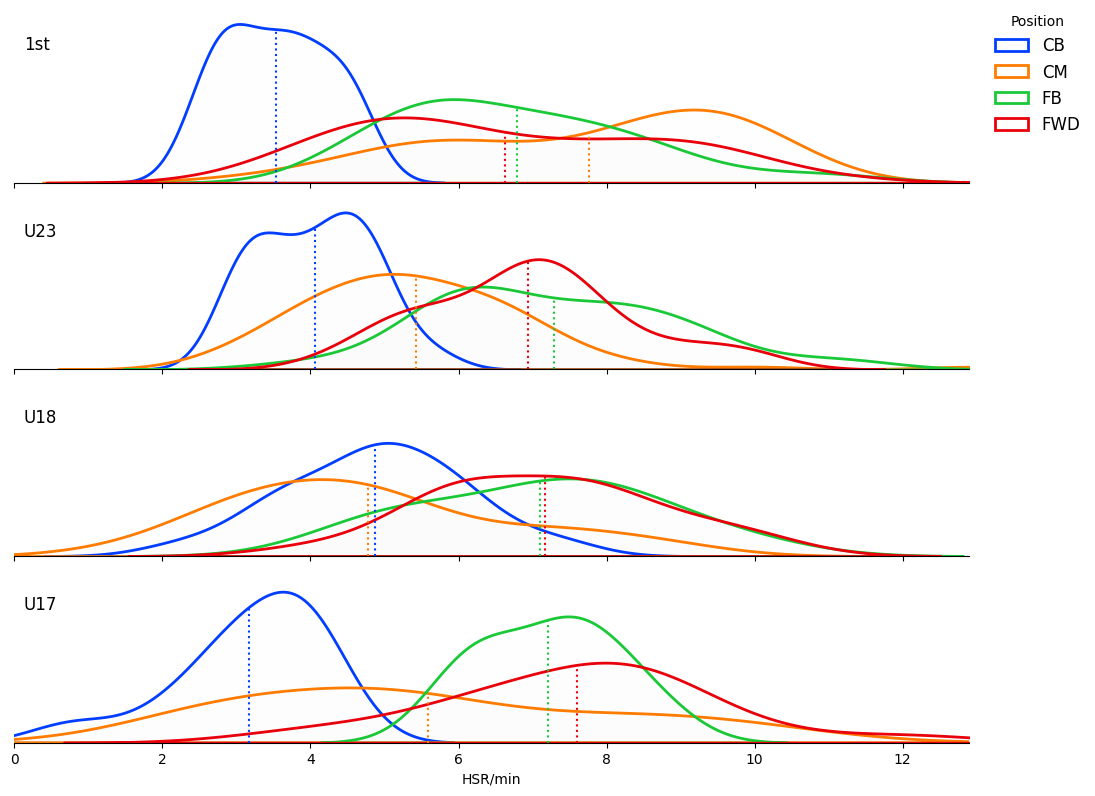

In [24]:
g = sns.FacetGrid(df, row="team", hue="position", row_order=["1st", "U23", "U18", "U17"], height=2, aspect=5)
g.map(sns.kdeplot, measure, bw_adjust=1, fill=True, alpha=.005, lw=2)


for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
    ax.set_xlim(0, max(df[measure]))

# add mean lines        
for i, ax in enumerate(g.axes.flat):
    for j, collection in enumerate(ax.collections):

        # Mean required to calulate x position of mean line
        df_p = df[(df["position"] == g.hue_names[j]) & (df["team"] == g.row_names[i])]
        mean = df_p[measure].mean()
        stdv = np.std(df_p[measure])

        # vertices need to have y=0 coords filtered out for interp to work
        vertices = collection.get_paths()[0].vertices
        vertices = vertices[vertices.T[1] > 0]

        # bubble sort to reduce risk of stack overflow?
        x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])
        mean_height = np.interp(mean, x_coords, y_coords)
        stdm_height = np.interp(mean - stdv, x_coords, y_coords)
        stdp_height = np.interp(mean + stdv, x_coords, y_coords)

        ax.vlines(mean,0,mean_height, ls=":", colors=sns.color_palette("bright")[j])
        # ax.fill_between(x_coords, 0, y_coords, where=(mean - stdv <= x_coords) & (x_coords <= mean + stdv), interpolate=False, facecolor=sns.color_palette("bright")[j], alpha=0.2)

        # ax.vlines(mean - stdv,0,stdm_height, ls=":", colors=sns.color_palette("bright")[j])
        # ax.vlines(mean + stdv,0,stdp_height, ls=":", colors=sns.color_palette("bright")[j])
        
        
    
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)
g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)






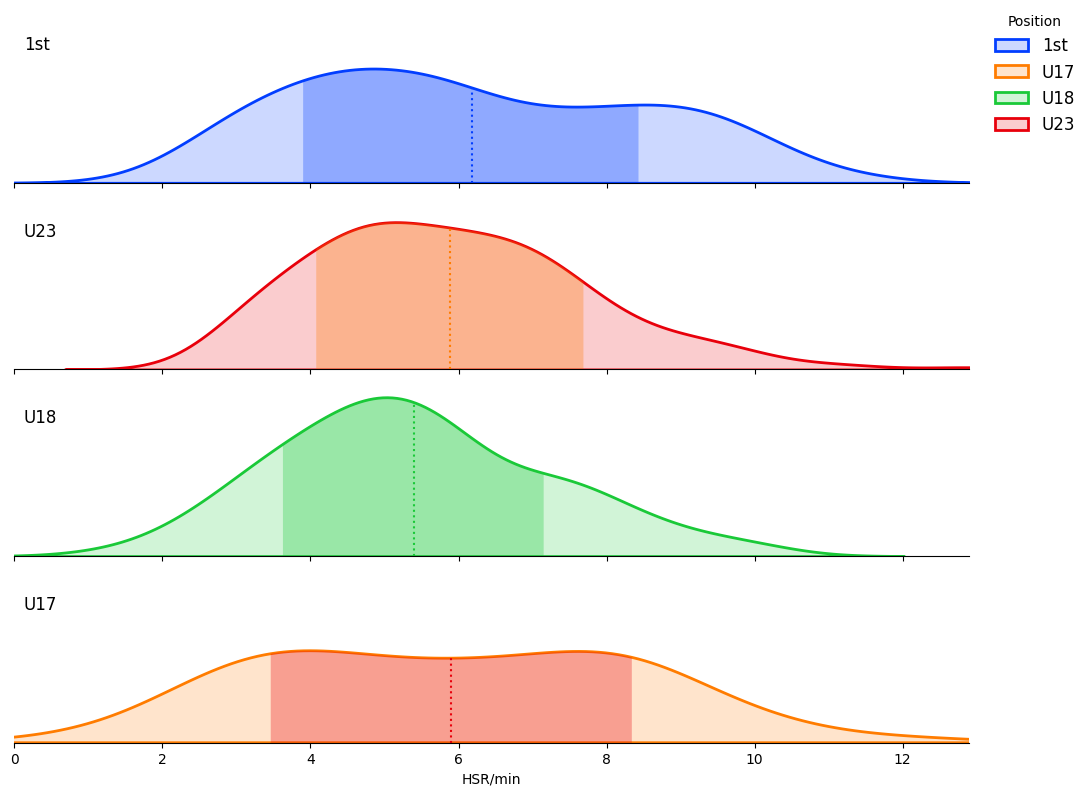

In [40]:
g = sns.FacetGrid(df, row="team", hue="team", row_order=["1st", "U23", "U18", "U17"], height=2, aspect=5)
g.map(sns.kdeplot, measure, bw_adjust=1, fill=True, alpha=.2, lw=2)


for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
    ax.set_xlim(0, max(df[measure]))

# add mean lines        
for i, ax in enumerate(g.axes.flat):
    for j, collection in enumerate(ax.collections):

        # Mean required to calulate x position of mean line
        df_p = df[ (df["team"] == g.row_names[i])]
        mean = df_p[measure].mean()
        stdv = np.std(df_p[measure])
        
        # vertices need to have y=0 coords filtered out for interp to work
        vertices = collection.get_paths()[0].vertices
        vertices = vertices[vertices.T[1] > 0]

        # bubble sort to reduce risk of stack overflow?
        x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])
        mean_height = np.interp(mean, x_coords, y_coords)
        stdm_height = np.interp(mean - stdv, x_coords, y_coords)
        stdp_height = np.interp(mean + stdv, x_coords, y_coords)

        ax.vlines(mean,0,mean_height, ls=":", colors=sns.color_palette("bright")[i])
        ax.fill_between(x_coords, 0, y_coords, where=(mean - stdv <= x_coords) & (x_coords <= mean + stdv), interpolate=False, facecolor=sns.color_palette("bright")[i], alpha=0.3)

        # ax.vlines(mean - stdv,0,stdm_height, ls=":", colors=sns.color_palette("bright")[j])
        # ax.vlines(mean + stdv,0,stdp_height, ls=":", colors=sns.color_palette("bright")[j])
        
        
    
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)
g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)


mean: 3.1763416974039798
height: 0.36730504621507537


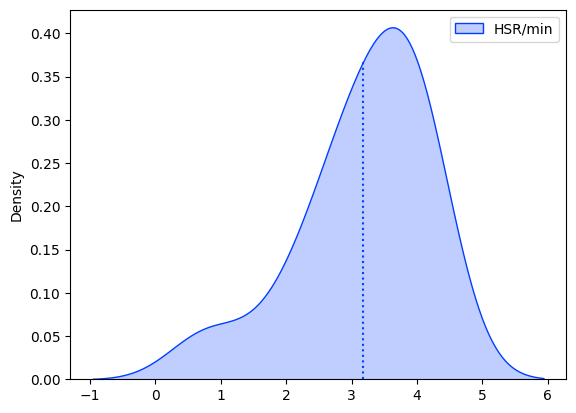

In [26]:
df_p = df[(df["position"] == "CB") & (df["team"] == "U17")]

mean = df_p[measure].mean()
print(f"mean: {mean}")
g = sns.kdeplot(data=df_p, fill=True)

vertices = g.collections[0].get_paths()[0].vertices

vertices = vertices[vertices.T[1] > 0]

# Order x axis
x_coords, y_coords = bubblesort_by_x(vertices.T[0], vertices.T[1])

height = np.interp(mean, x_coords, y_coords)

height1 = interpolate_2D_array(vertices, mean)

print(f"height: {height}")
# print(f"height2: {height2}")
g.vlines(mean,0,height, ls=":")

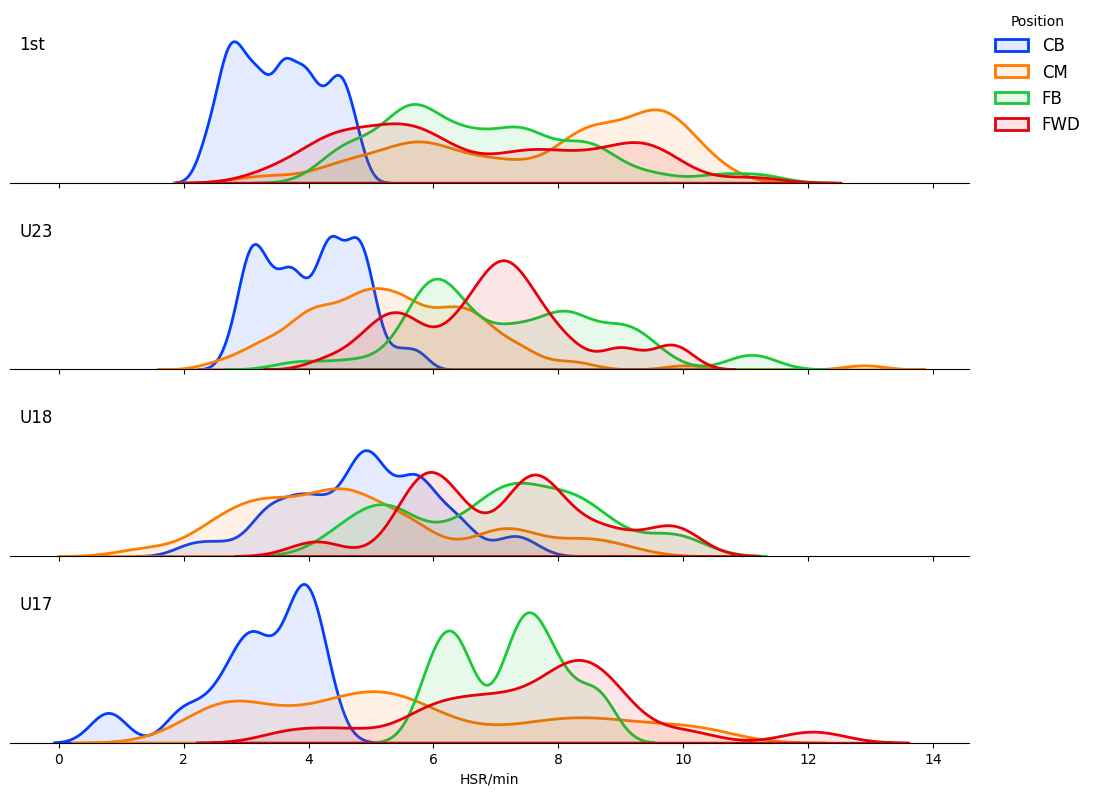

In [27]:
g = sns.FacetGrid(df, row="team", hue="position", row_order=["1st", "U23", "U18", "U17"], height=2, aspect=5)
g.map(sns.kdeplot, measure, bw_adjust=0.5, fill=True, alpha=.1, lw=2)

for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)
g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)


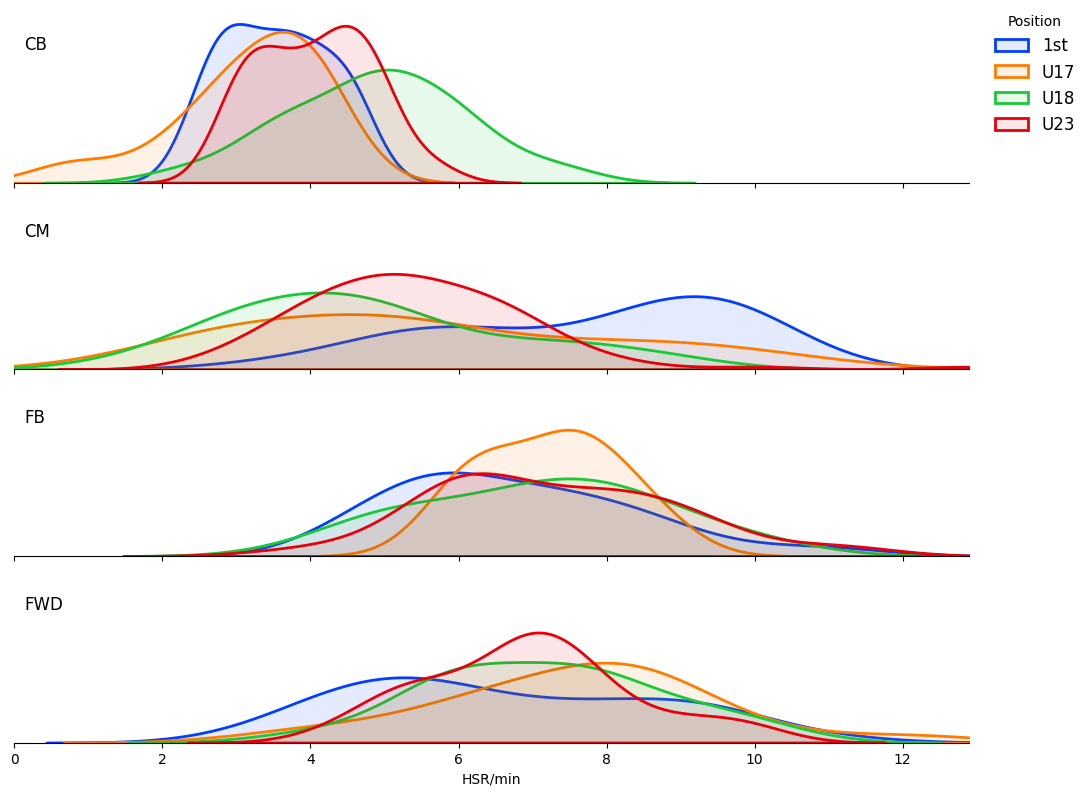

In [28]:
g = sns.FacetGrid(df, row="position", hue="team", height=2, aspect=5)
g.map(sns.kdeplot, measure, fill=True, alpha=.1, lw=2)


for i, ax in enumerate(g.axes.flat):
    ax.text(0.01, 0.8, g.row_names[i],
            fontsize=12, transform = ax.transAxes)
    ax.set_xlim(0, max(df[measure]))
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)

g.add_legend(title="Position", loc="upper right", fontsize=12)
g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)